In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA

np.random.seed(42)

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Import the HeLa gene-level profiles
df_gene_DMEM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
df_gene_HPLM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___HPLM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

# Load p_values from the hit calling process
df_p_values_DMEM = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_DMEM = df_p_values_DMEM.set_index('Gene')
df_p_values_HPLM = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_HPLM = df_p_values_HPLM.set_index('Gene')

# Import annotated gene sets
with open("../common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)

# Load expression data 
with open("../Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

# Extended Figure 8A

In [4]:
for p_values, condition in [(df_p_values_DMEM,'DMEM'),(df_p_values_HPLM,'HPLM')]:
    # Calculate the morphological signal scores for each perturbation and sort 
    p_values = p_values.loc[expressed_gene_list[:-1]]
    p_values_neg_log = -np.log10(p_values)
    ranked_list = pd.DataFrame(((p_values <= 0.001) * p_values_neg_log).sum(axis=1).sort_values(ascending=False))
    ranked_list = ranked_list.reset_index().rename(columns={'Gene':'GID',0:''})
    ranked_list.to_csv(os.path.join(output_folder,f'HeLa_{condition}_all_genes.rnk'), sep='\t', index=False)
ranked_list.head()

,GID,
0,ATP2A2,7208.687082
1,ILK,6955.854113
2,RAC1,6368.172435
3,EIF4E,6367.152512
4,ITGB1,6258.312566


# Extended Figures 8B and 8C

In [5]:
# Perform principal component analysis on gene aggregated profiles
df_gene_pca_dict = {}
for (df_gene, condition) in [(df_gene_DMEM, 'DMEM'), (df_gene_HPLM, 'HPLM')]:
    pca = PCA()
    pca.fit(df_gene)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 70% variation
    PCA_lookup = {}
    for i in range(len(x)):
        distance = abs(.7-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 70% variation is {component}')
    # Perform principal component analysis and select components representing 70% of variation in data
    pca = PCA(n_components=component)
    df_gene_pca = pd.DataFrame(pca.fit_transform(df_gene),index=df_gene.index).reset_index().set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    df_gene_pca_dict[condition] = df_gene_pca
df_gene_pca.head()

For DMEM, principal component representing closest to 70% variation is 215
For HPLM, principal component representing closest to 70% variation is 160


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
A1BG,1.631312,1.613159,3.014042,-1.749491,0.747655,-2.263314,1.621407,0.580308,0.266791,-1.611416,...,-0.623711,-0.494154,-0.020183,-0.156282,-0.116374,-0.070004,-0.135541,0.276830,-0.180785,-0.106070
A1CF,2.979367,3.591269,-0.149918,-1.388088,0.091967,0.088882,-0.042084,0.026289,0.206233,-0.620842,...,0.247135,-0.220222,0.110832,-0.253924,-0.100319,-0.305228,0.139922,0.299223,-0.446545,0.088622
A2M,1.769034,-1.775785,-1.059892,-4.576765,-0.036606,2.896833,1.086686,-0.909597,-1.201923,-0.162276,...,-0.119809,-0.230151,-0.133089,-0.122595,0.240065,-0.170236,0.422506,0.186181,0.063665,-0.214587
A2ML1,-0.131835,-1.229280,3.069760,0.342828,-0.749012,-0.735887,-0.533491,-0.871848,-0.940486,-0.879810,...,0.169488,-0.134412,-0.153899,-0.068539,0.197353,-0.121292,0.158924,0.148762,-0.269270,0.265263
A3GALT2,-2.508585,-1.732827,-0.752530,0.367364,-3.609211,1.289250,1.666406,0.514052,-1.400885,1.689305,...,-0.075589,-0.305271,0.047502,0.144810,0.312422,-0.149641,0.328265,0.045993,-0.147250,0.010757


In [6]:
def coupled_heatmap(profile_df_1,profile_df_2,gene_set,genes,naming,font_scale = 3.5, alt_view=False):
    # Clustered based on the profile_df_1 arm first
    genes_df =  profile_df_1.loc[profile_df_1.index.isin(genes)]
    
    # Clustered based on the profile_df_1 arm first
    data = genes_df.T
    corr = data.corr()

    sns.set_theme(font_scale=font_scale,rc={'figure.figsize':(30,30)})
    ax = sns.clustermap(
        corr, 
        vmin=-1, vmax=1, center=0,
        method = 'ward',
    )

    # Clustered based on the profile_df_1 arm first
    profile_df_1_gene_list = list(genes_df.index)

    profile_df_1_cluster_order = ax.dendrogram_row.reordered_ind
    profile_df_1_cluster_list = [profile_df_1_gene_list[i] for i in profile_df_1_cluster_order]

    profile_df_2_gene_df =  profile_df_2.loc[profile_df_2.index.isin(profile_df_1_cluster_list)]
    profile_df_2_gene_profiles = profile_df_2_gene_df.reindex(profile_df_1_cluster_list)
    profile_df_1_gene_profiles = genes_df.reindex(profile_df_1_cluster_list)

    profile_df_1_data = profile_df_1_gene_profiles.T
    profile_df_1_corr = profile_df_1_data.corr()

    profile_df_2_data = profile_df_2_gene_profiles.T
    profile_df_2_corr = profile_df_2_data.corr()
    corr = profile_df_2_corr.copy()
    for i in range(len(profile_df_1_corr)):
        for j in range(len(profile_df_1_corr)):
            if i > j:
                corr.iat[i,j] = profile_df_1_corr.iat[i,j]
            elif i < j:
                corr.iat[i,j] = profile_df_2_corr.iat[i,j]
            elif i == j:
                corr.iat[i,j] = 1
    
    output_file = f'HeLa_median_plate_level_profile_heatmap_clustering_gene_hits_{gene_set}_{naming}.png'
    plt.clf()
    
    fig, ax = plt.subplots(figsize=(30, 30))

    ax = sns.heatmap(
                corr, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
                linewidth = 1,
                linecolor='white',
                cbar=False,
                cbar_kws={"shrink": .76}
    )
    
    # Turn the diagonals black
    ax = sns.heatmap(corr, mask = np.logical_not(np.diag(np.diag(corr))),linecolor='white', cmap = "mako", vmin=1, vmax=2,cbar=False)
    
    ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=90,
                horizontalalignment='right'
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
    ax.set(xlabel="", ylabel="")
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    plt.tight_layout()
    plt.show()
    if not alt_view:
        fig.savefig(os.path.join(output_folder,'figure_panels',output_file),dpi=300)
    else:
        if not os.path.exists(os.path.join(output_folder,"alternative_figure_panel_views")):
            os.makedirs(os.path.join(output_folder,"alternative_figure_panel_views"), exist_ok=True)
        fig.savefig(os.path.join(output_folder,"alternative_figure_panel_views",output_file),dpi=300)


<Figure size 1000x1000 with 0 Axes>

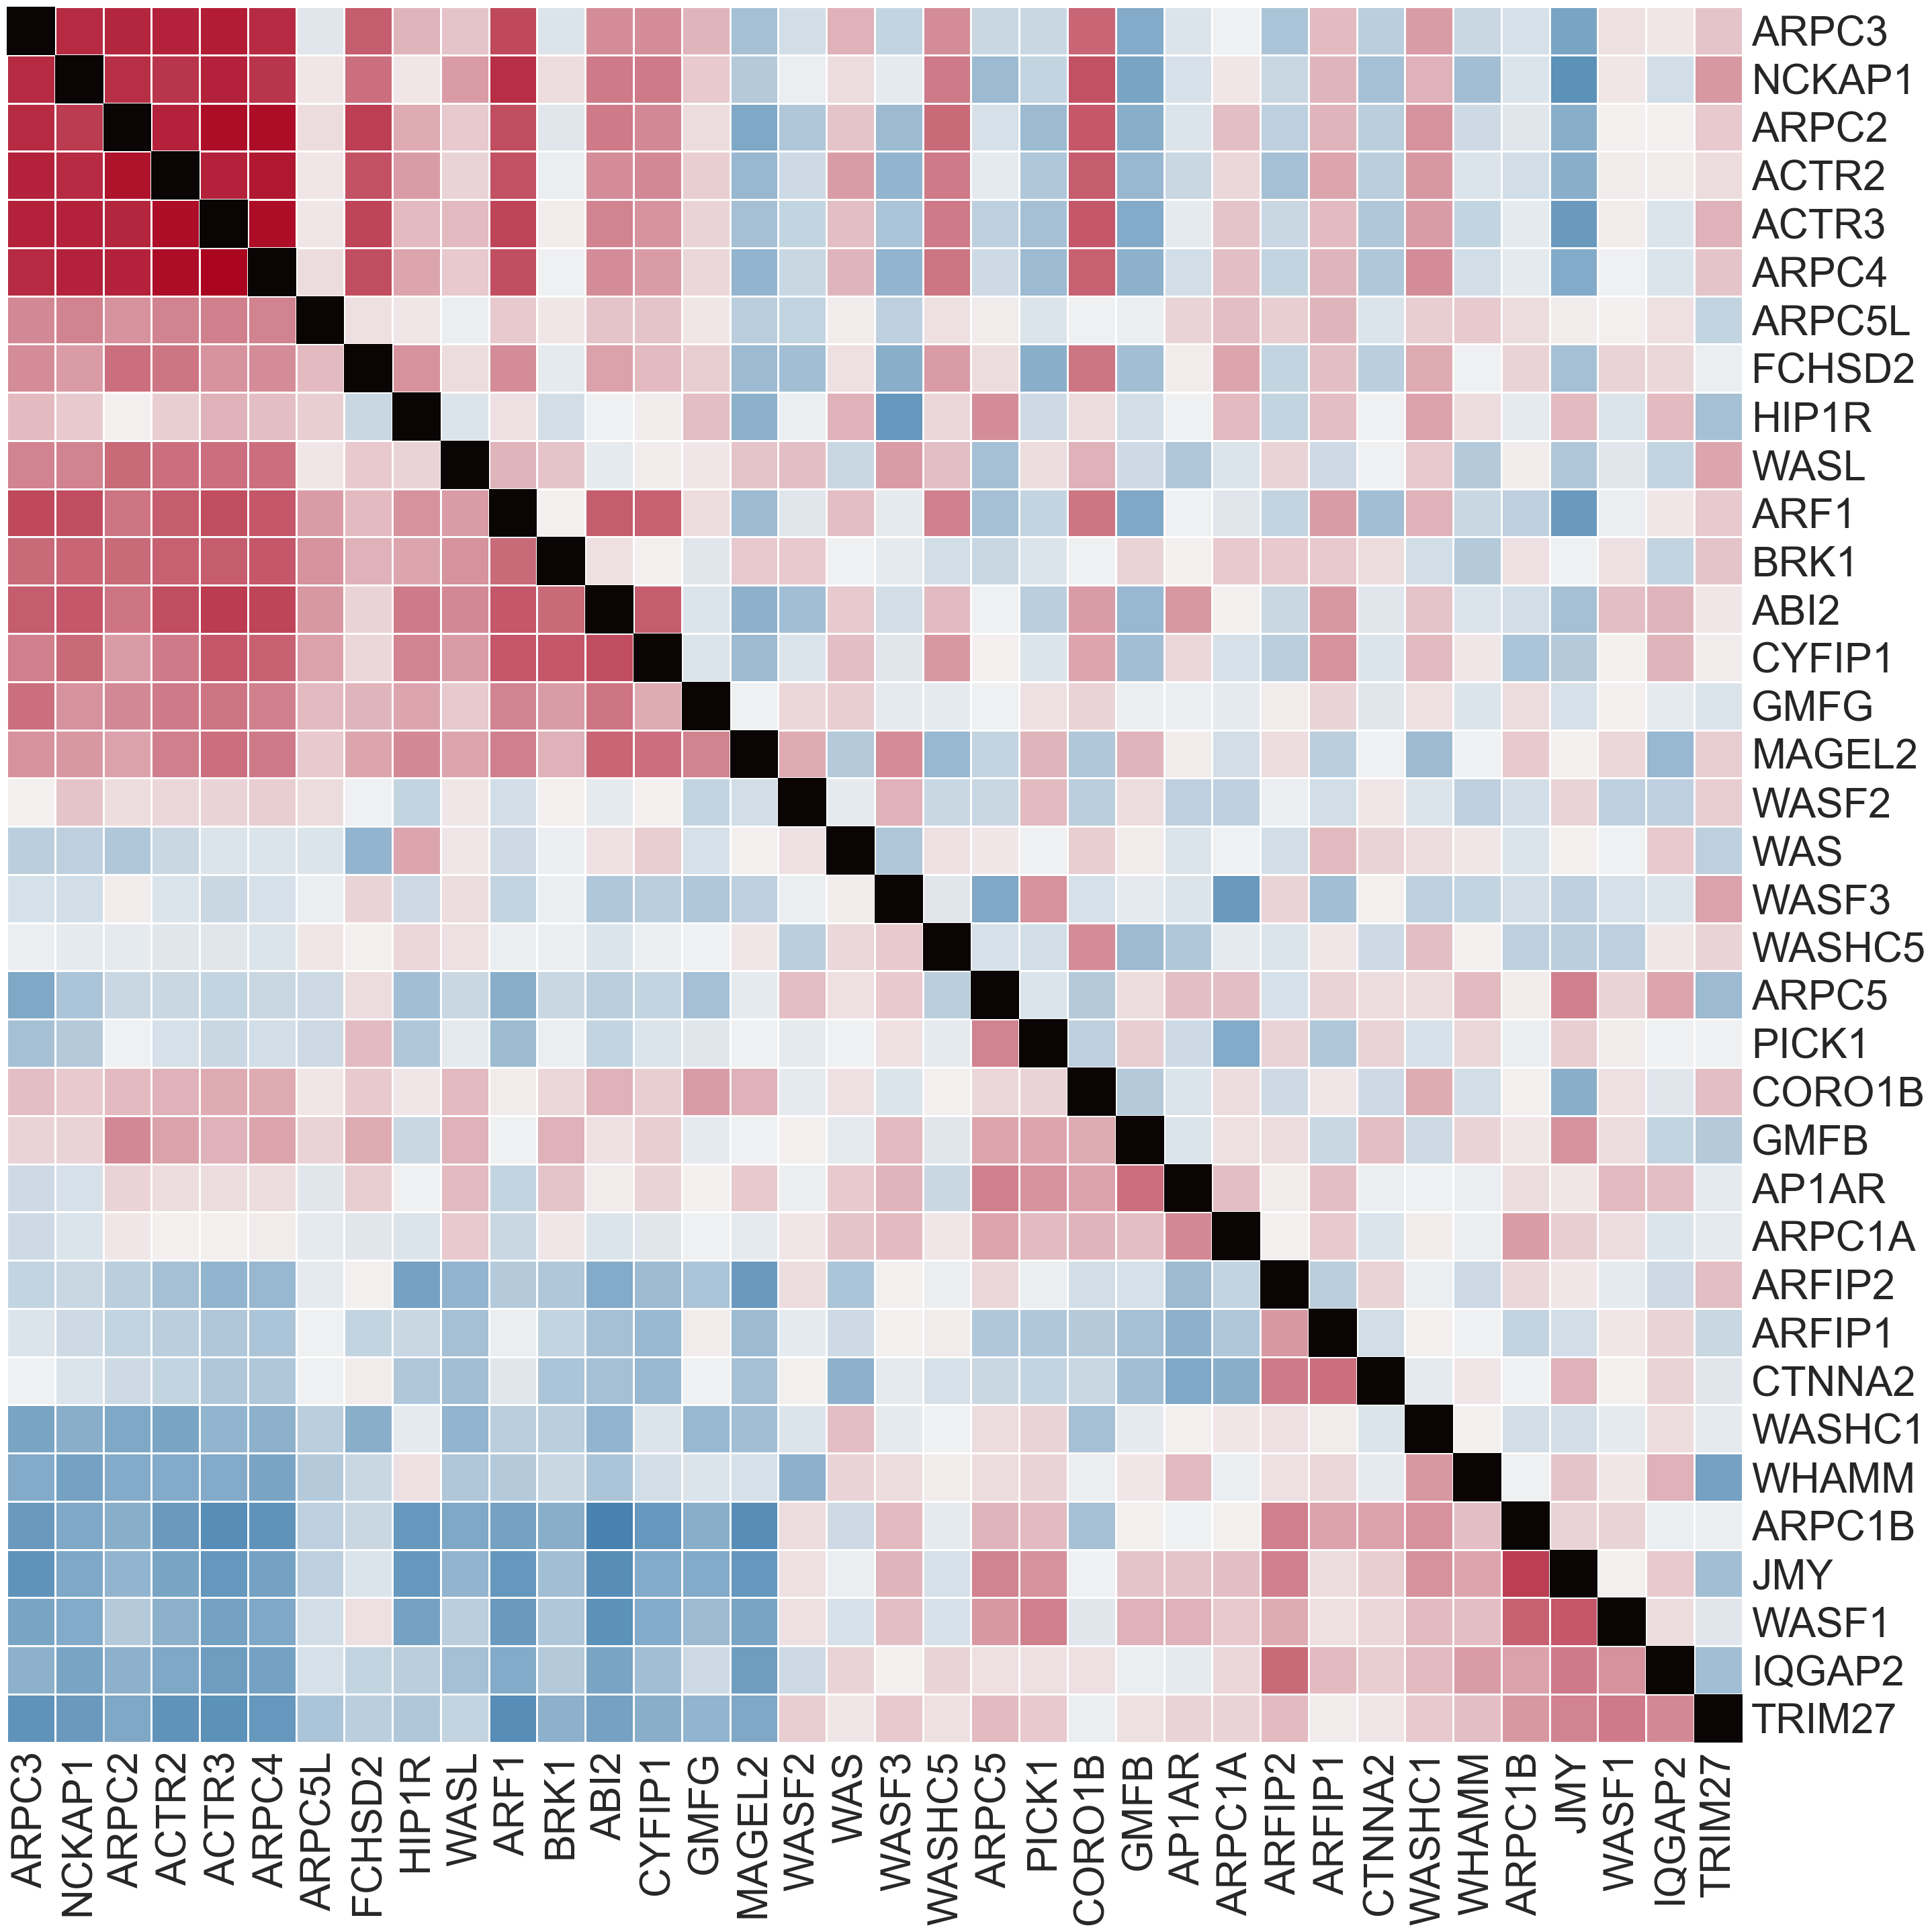

In [7]:
# Clustered based on the HPLM arm first
gene_set = 'ARP2_3_COMPLEX_MEDIATED_ACTIN_NUCLEATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first', 4 ,alt_view=True)

<Figure size 1000x1000 with 0 Axes>

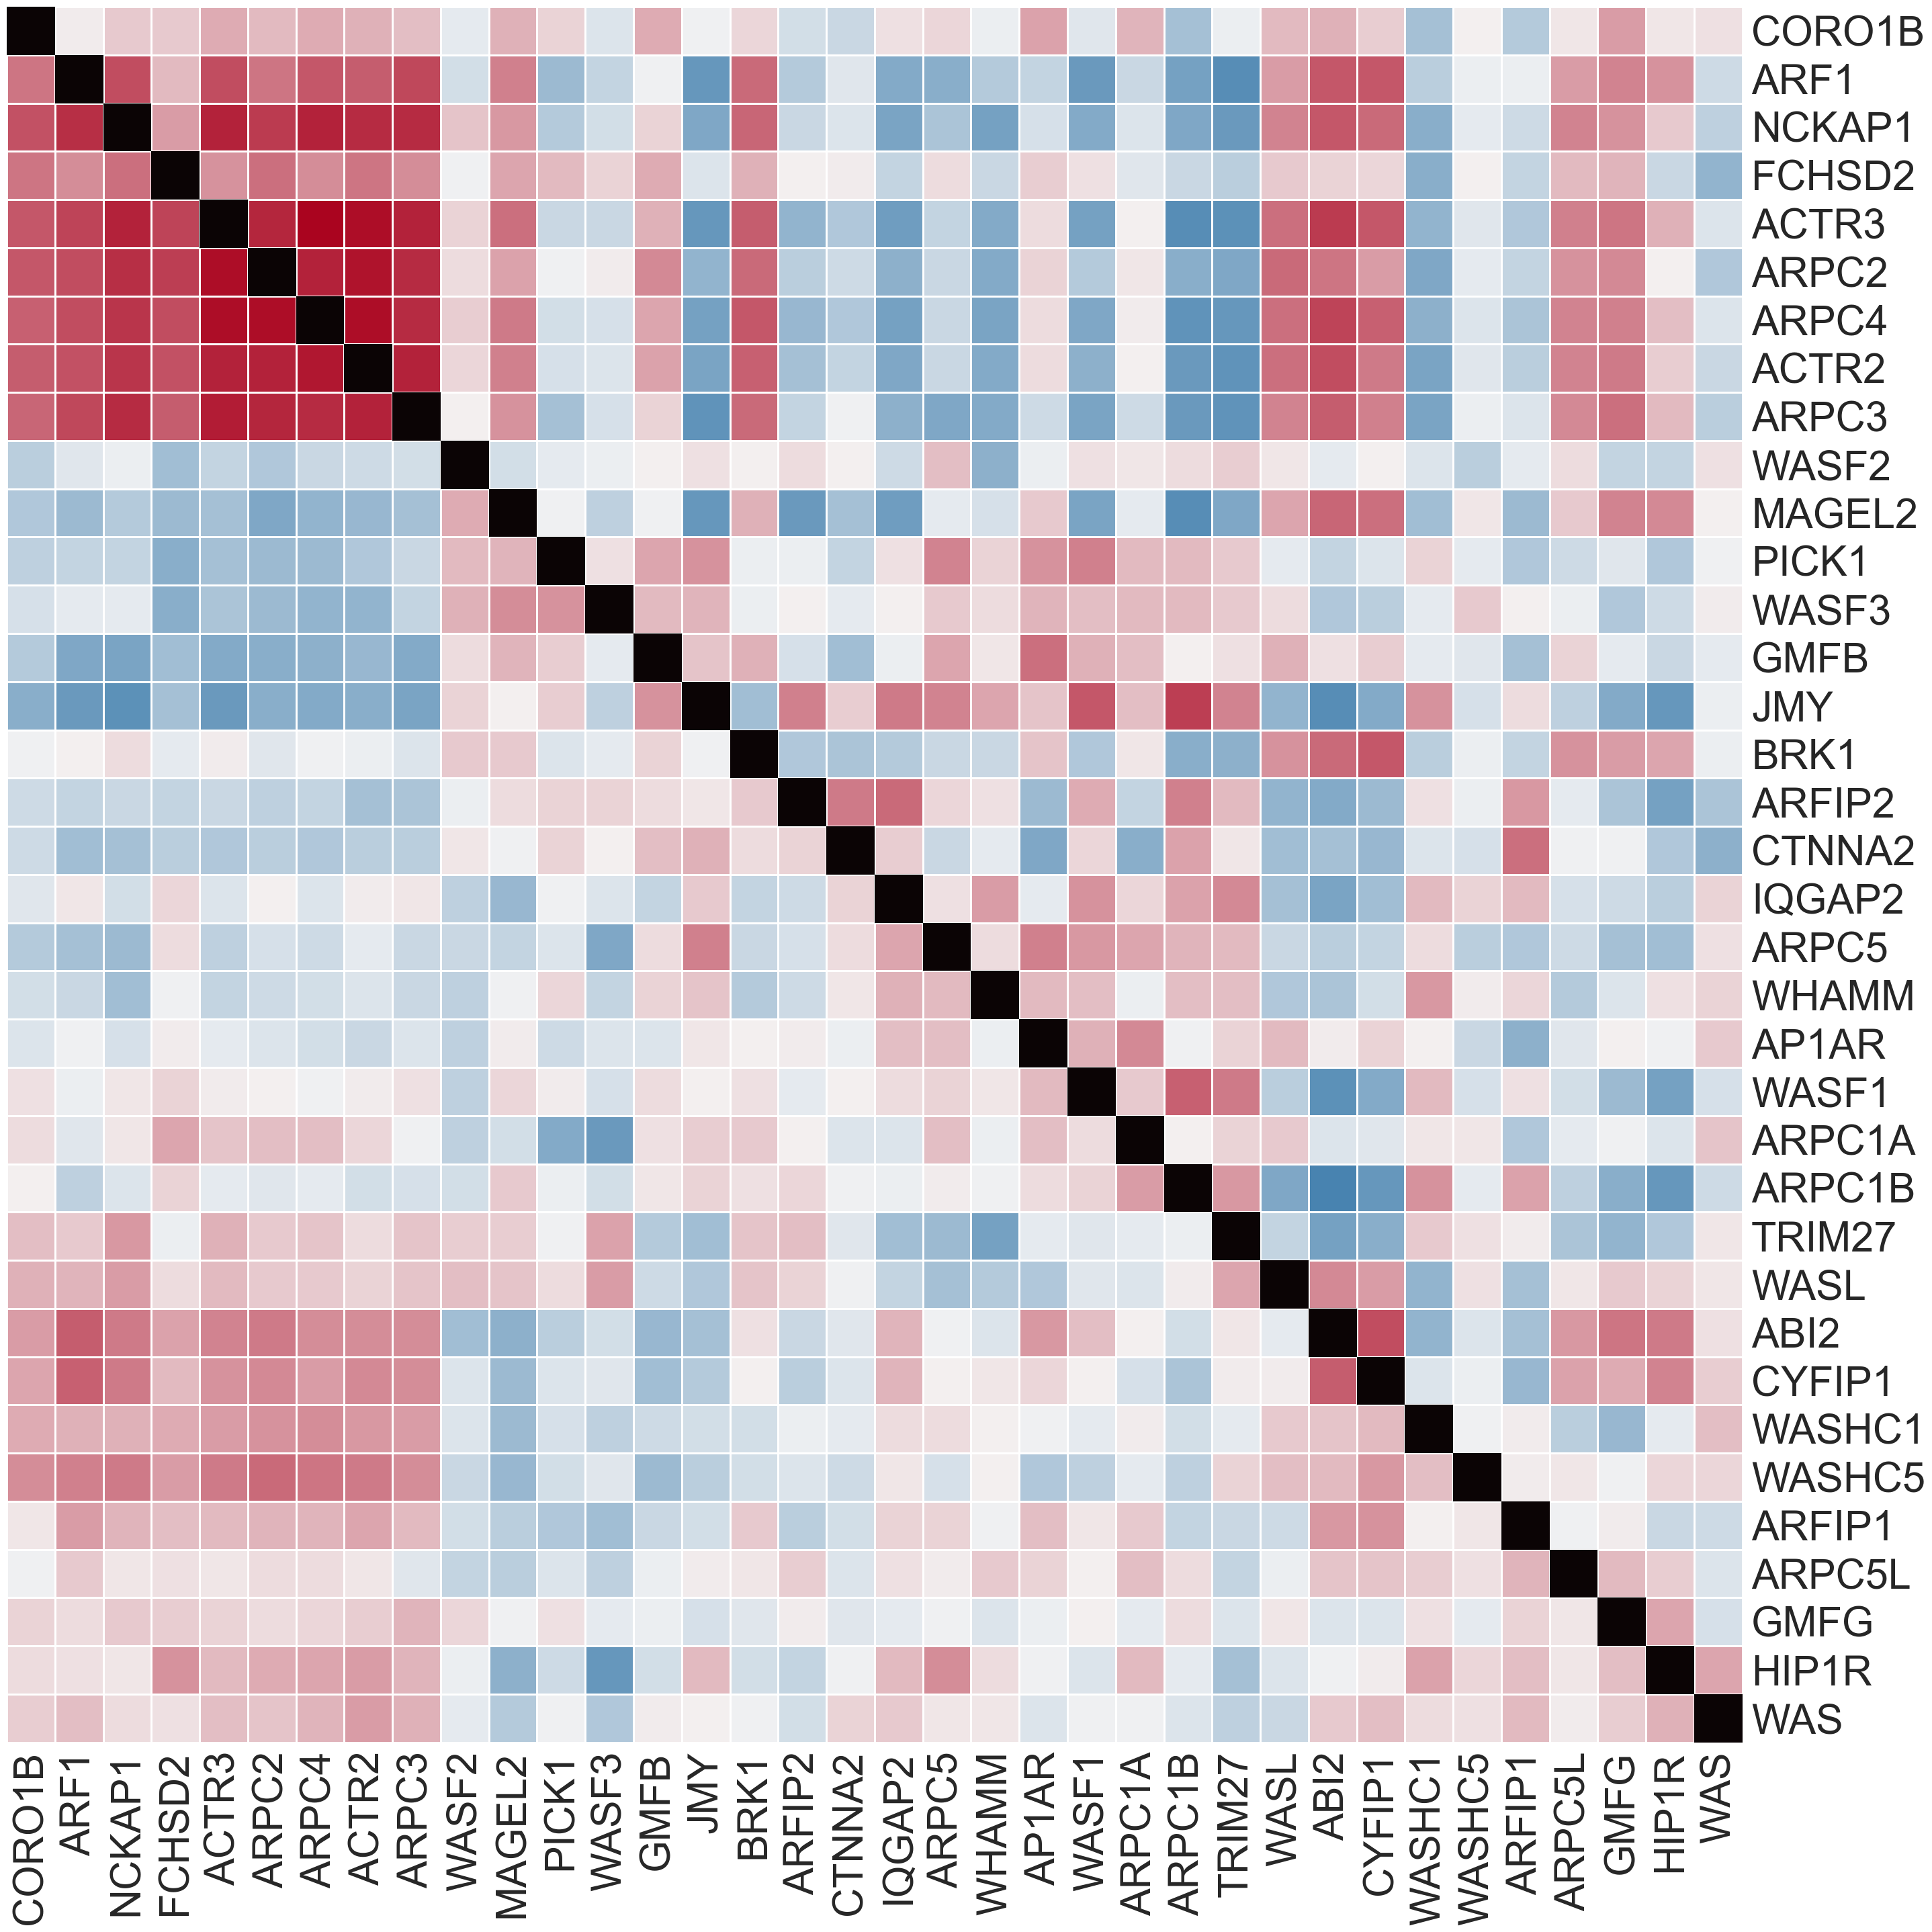

In [8]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first', 4)

<Figure size 1000x1000 with 0 Axes>

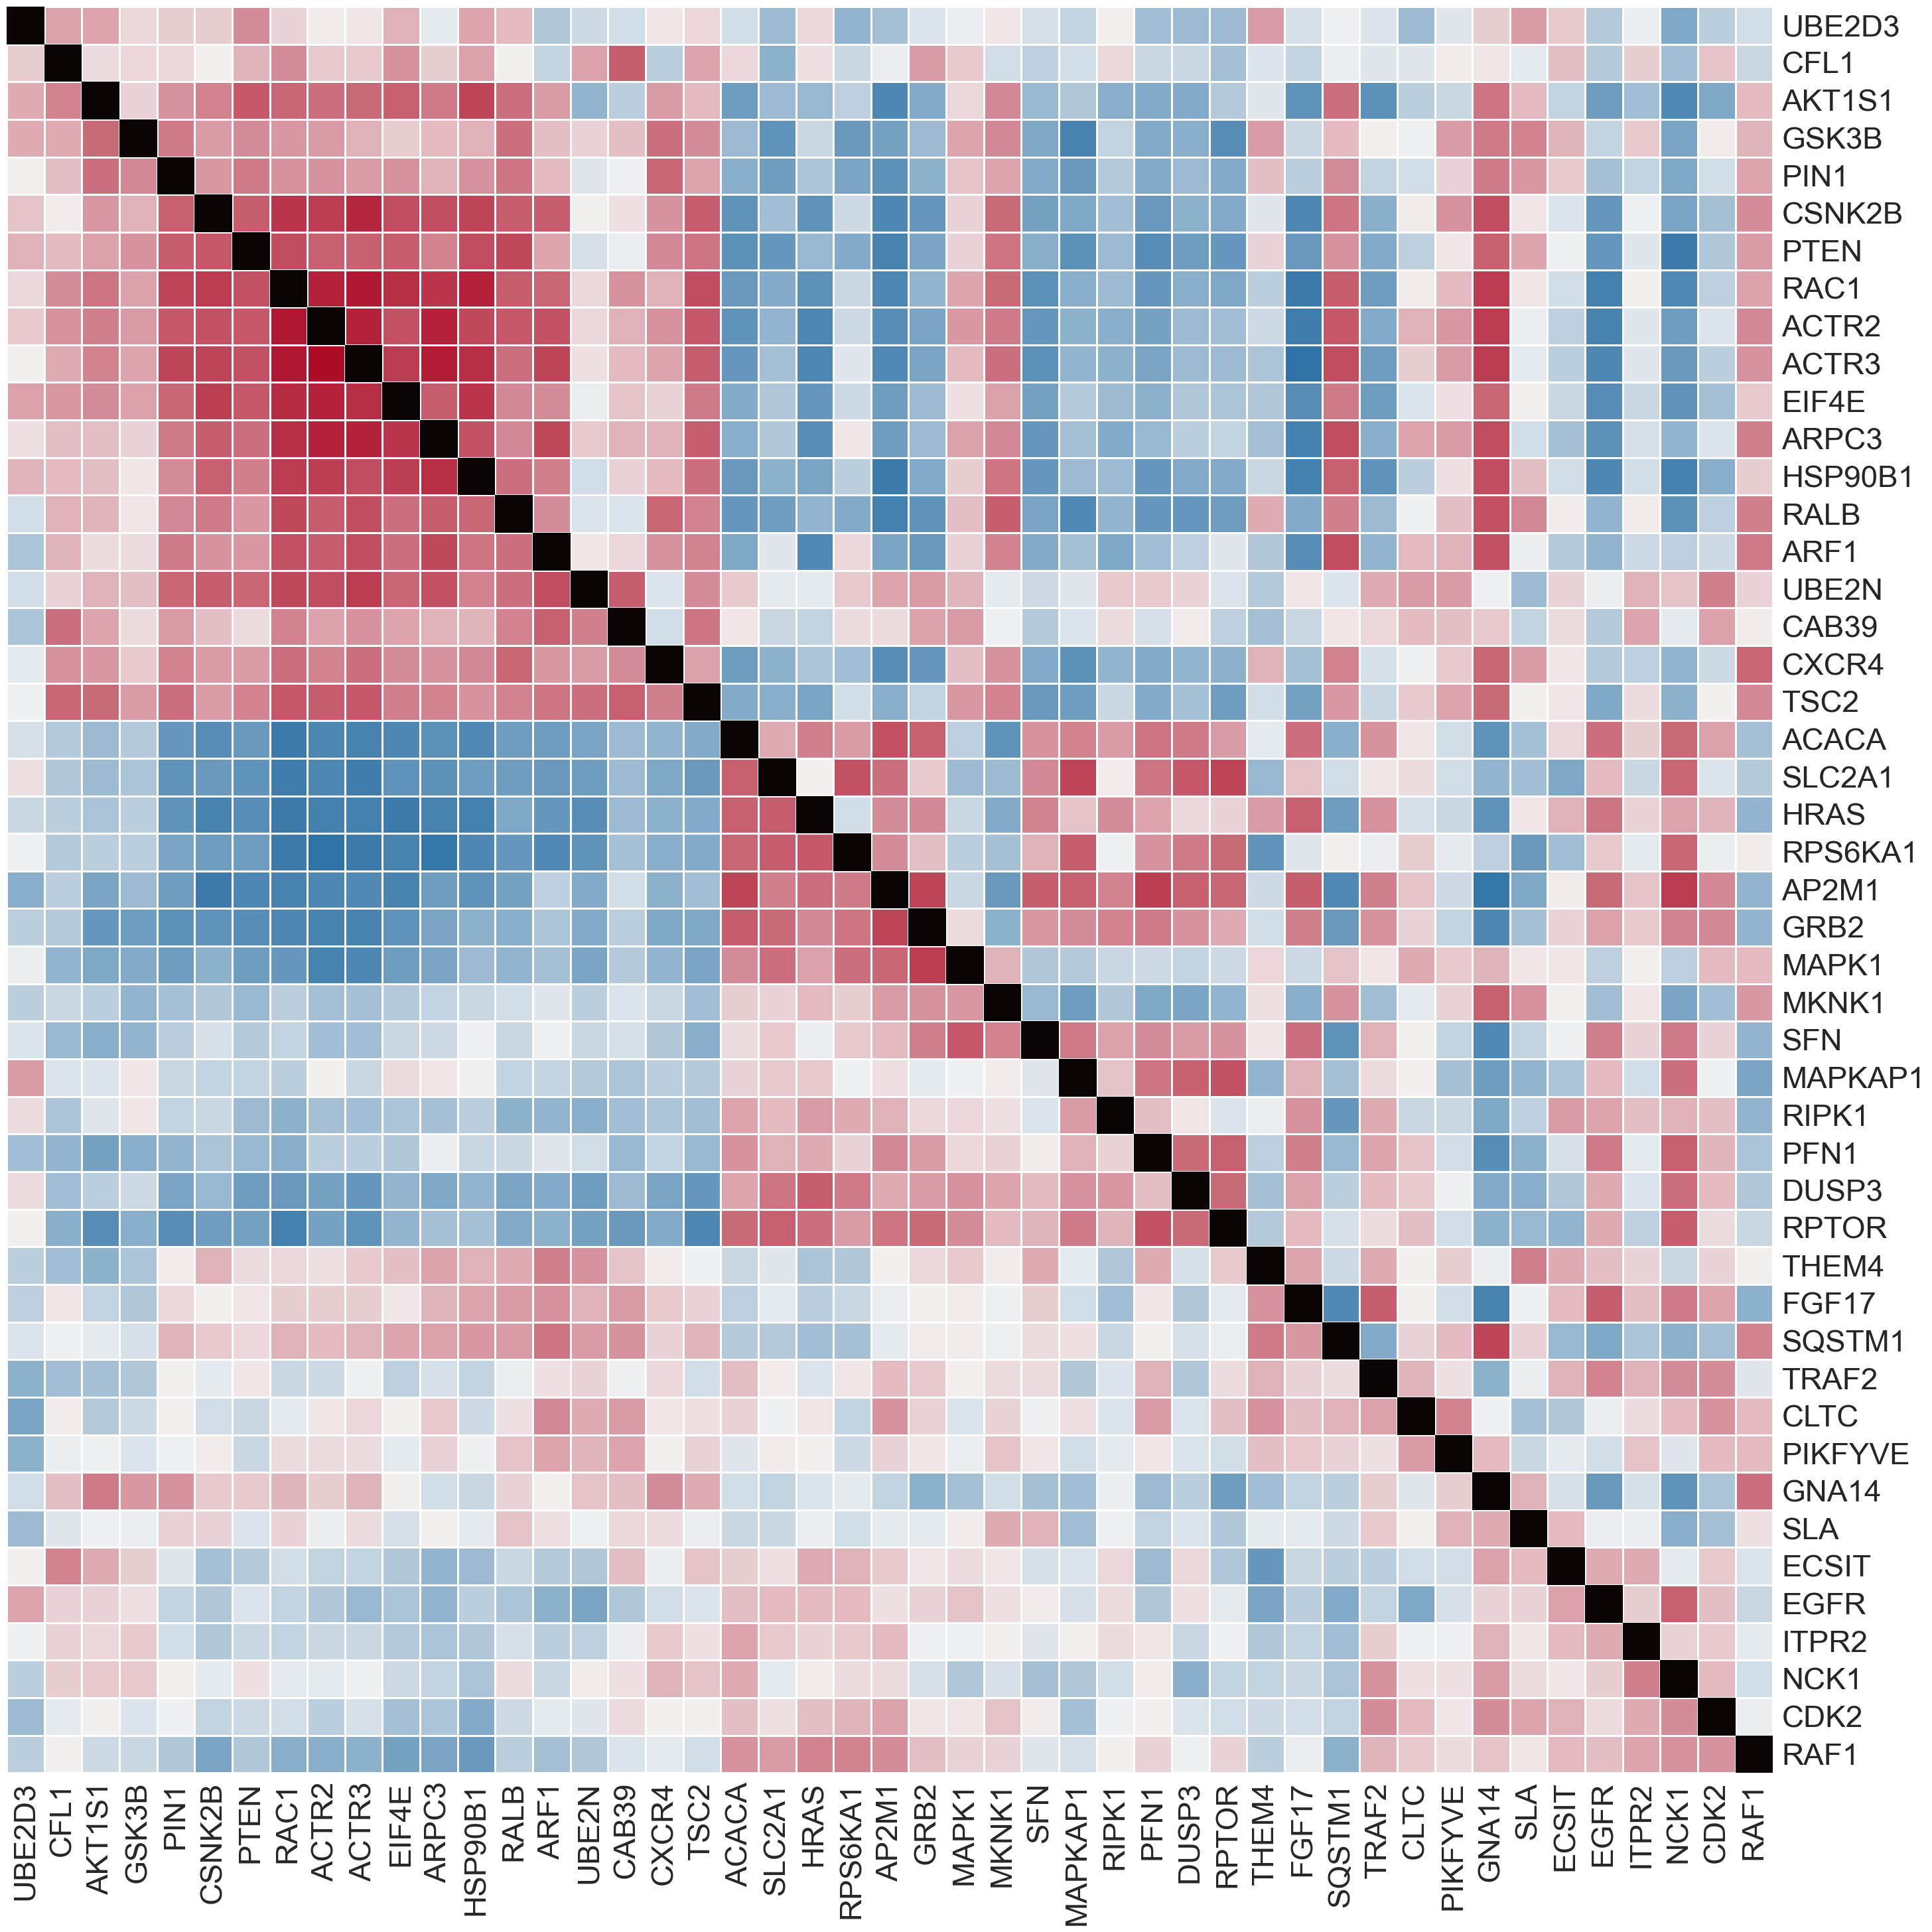

In [9]:
# Clustered based on the HPLM arm first
gene_set = 'PI3KAkt_mTOR_Signaling'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first', 3)

<Figure size 1000x1000 with 0 Axes>

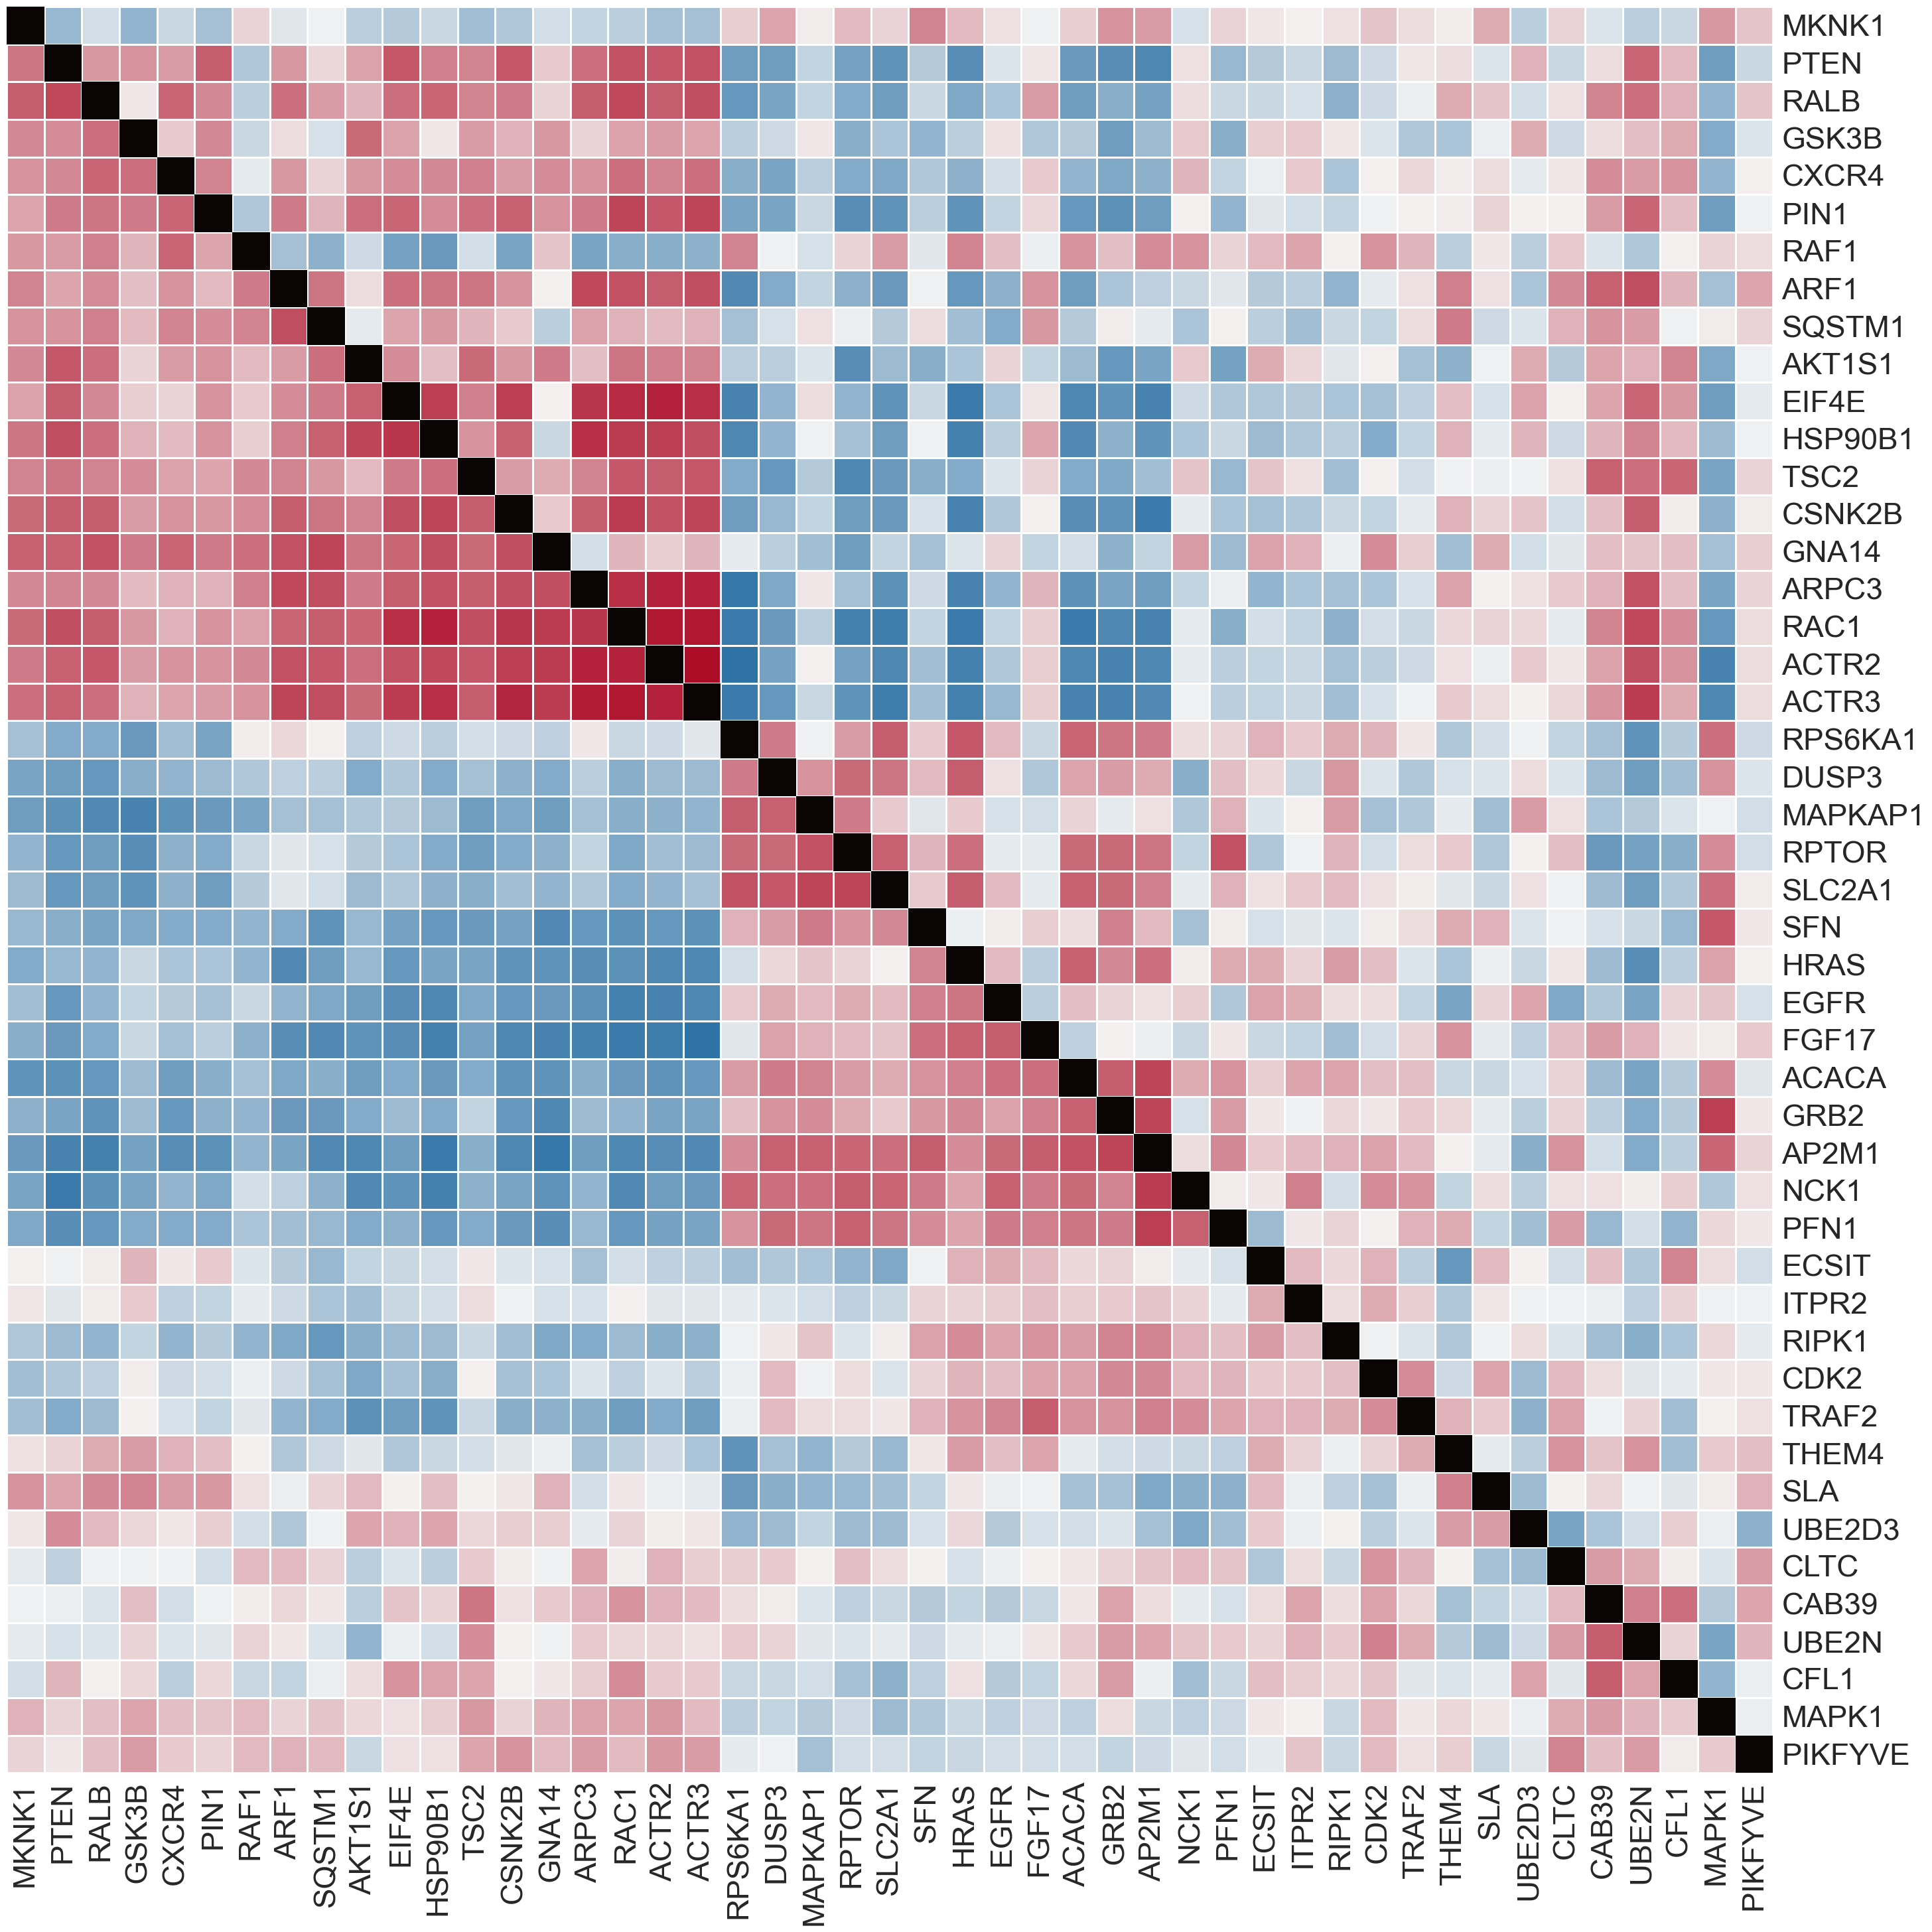

In [10]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first', 3 ,alt_view=True)

<Figure size 1000x1000 with 0 Axes>

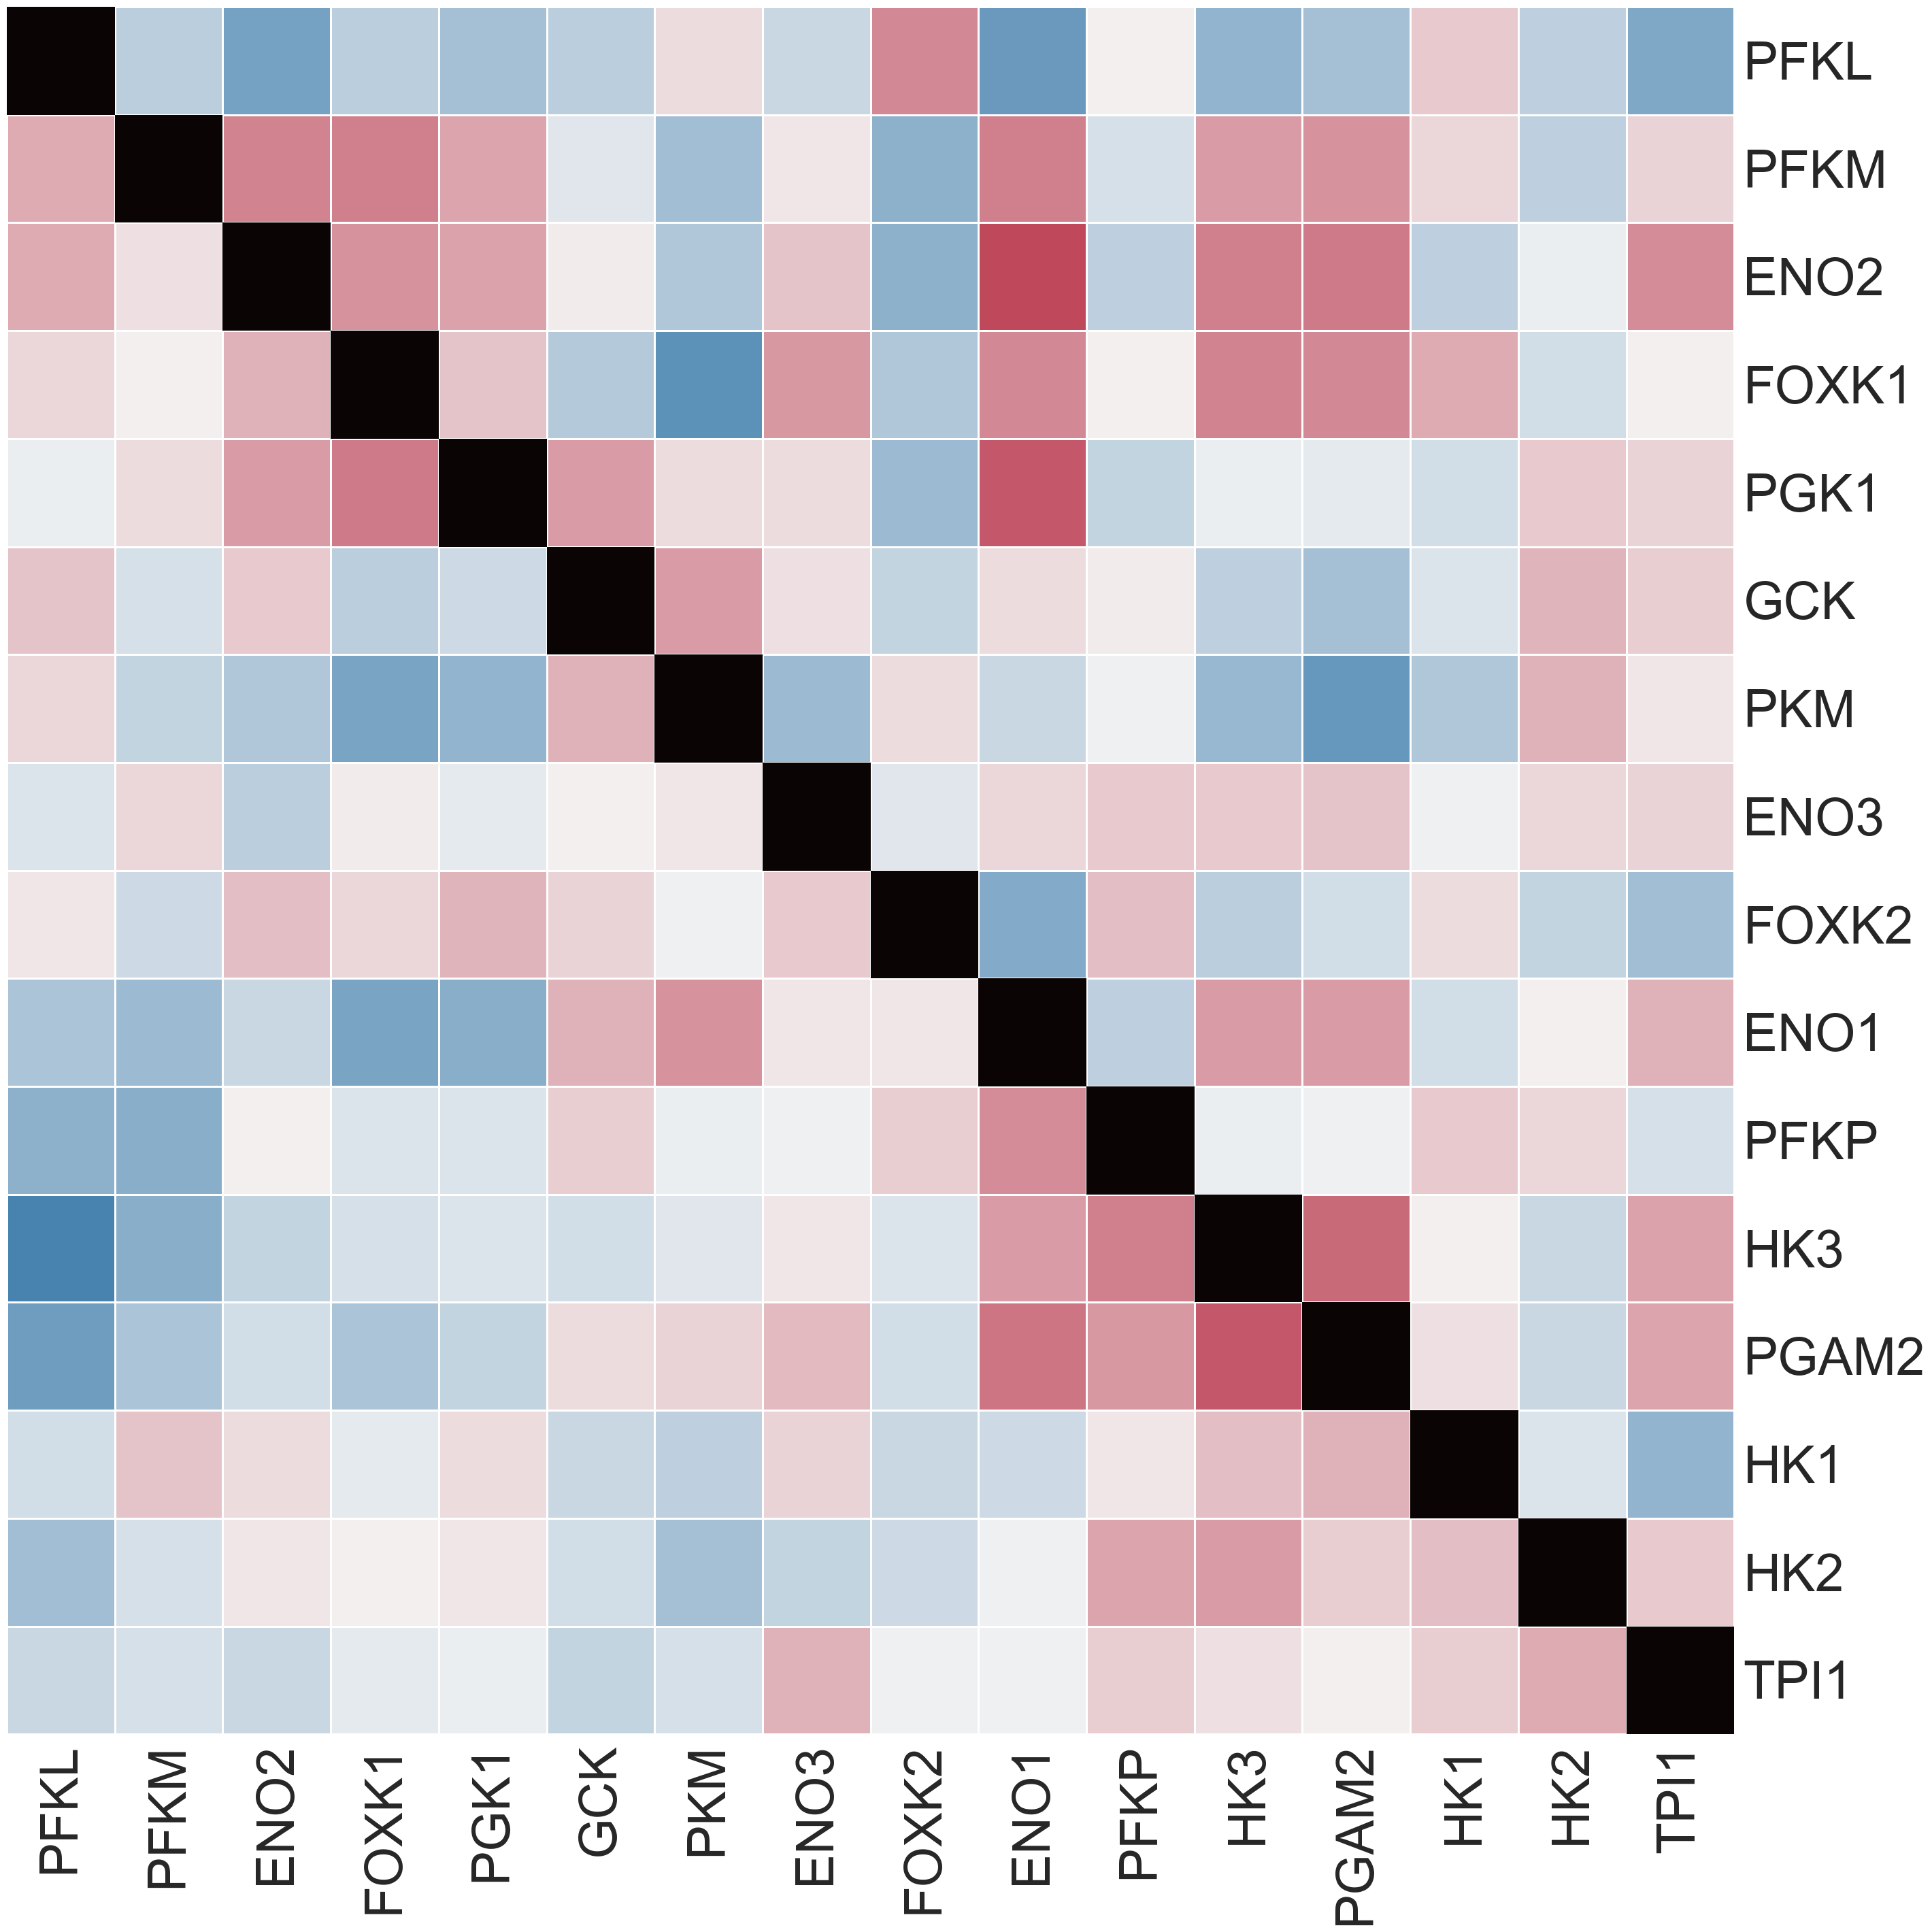

In [11]:
# Clustered based on the HPLM arm first
gene_set = 'NADH_REGENERATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',5,alt_view=True)

<Figure size 1000x1000 with 0 Axes>

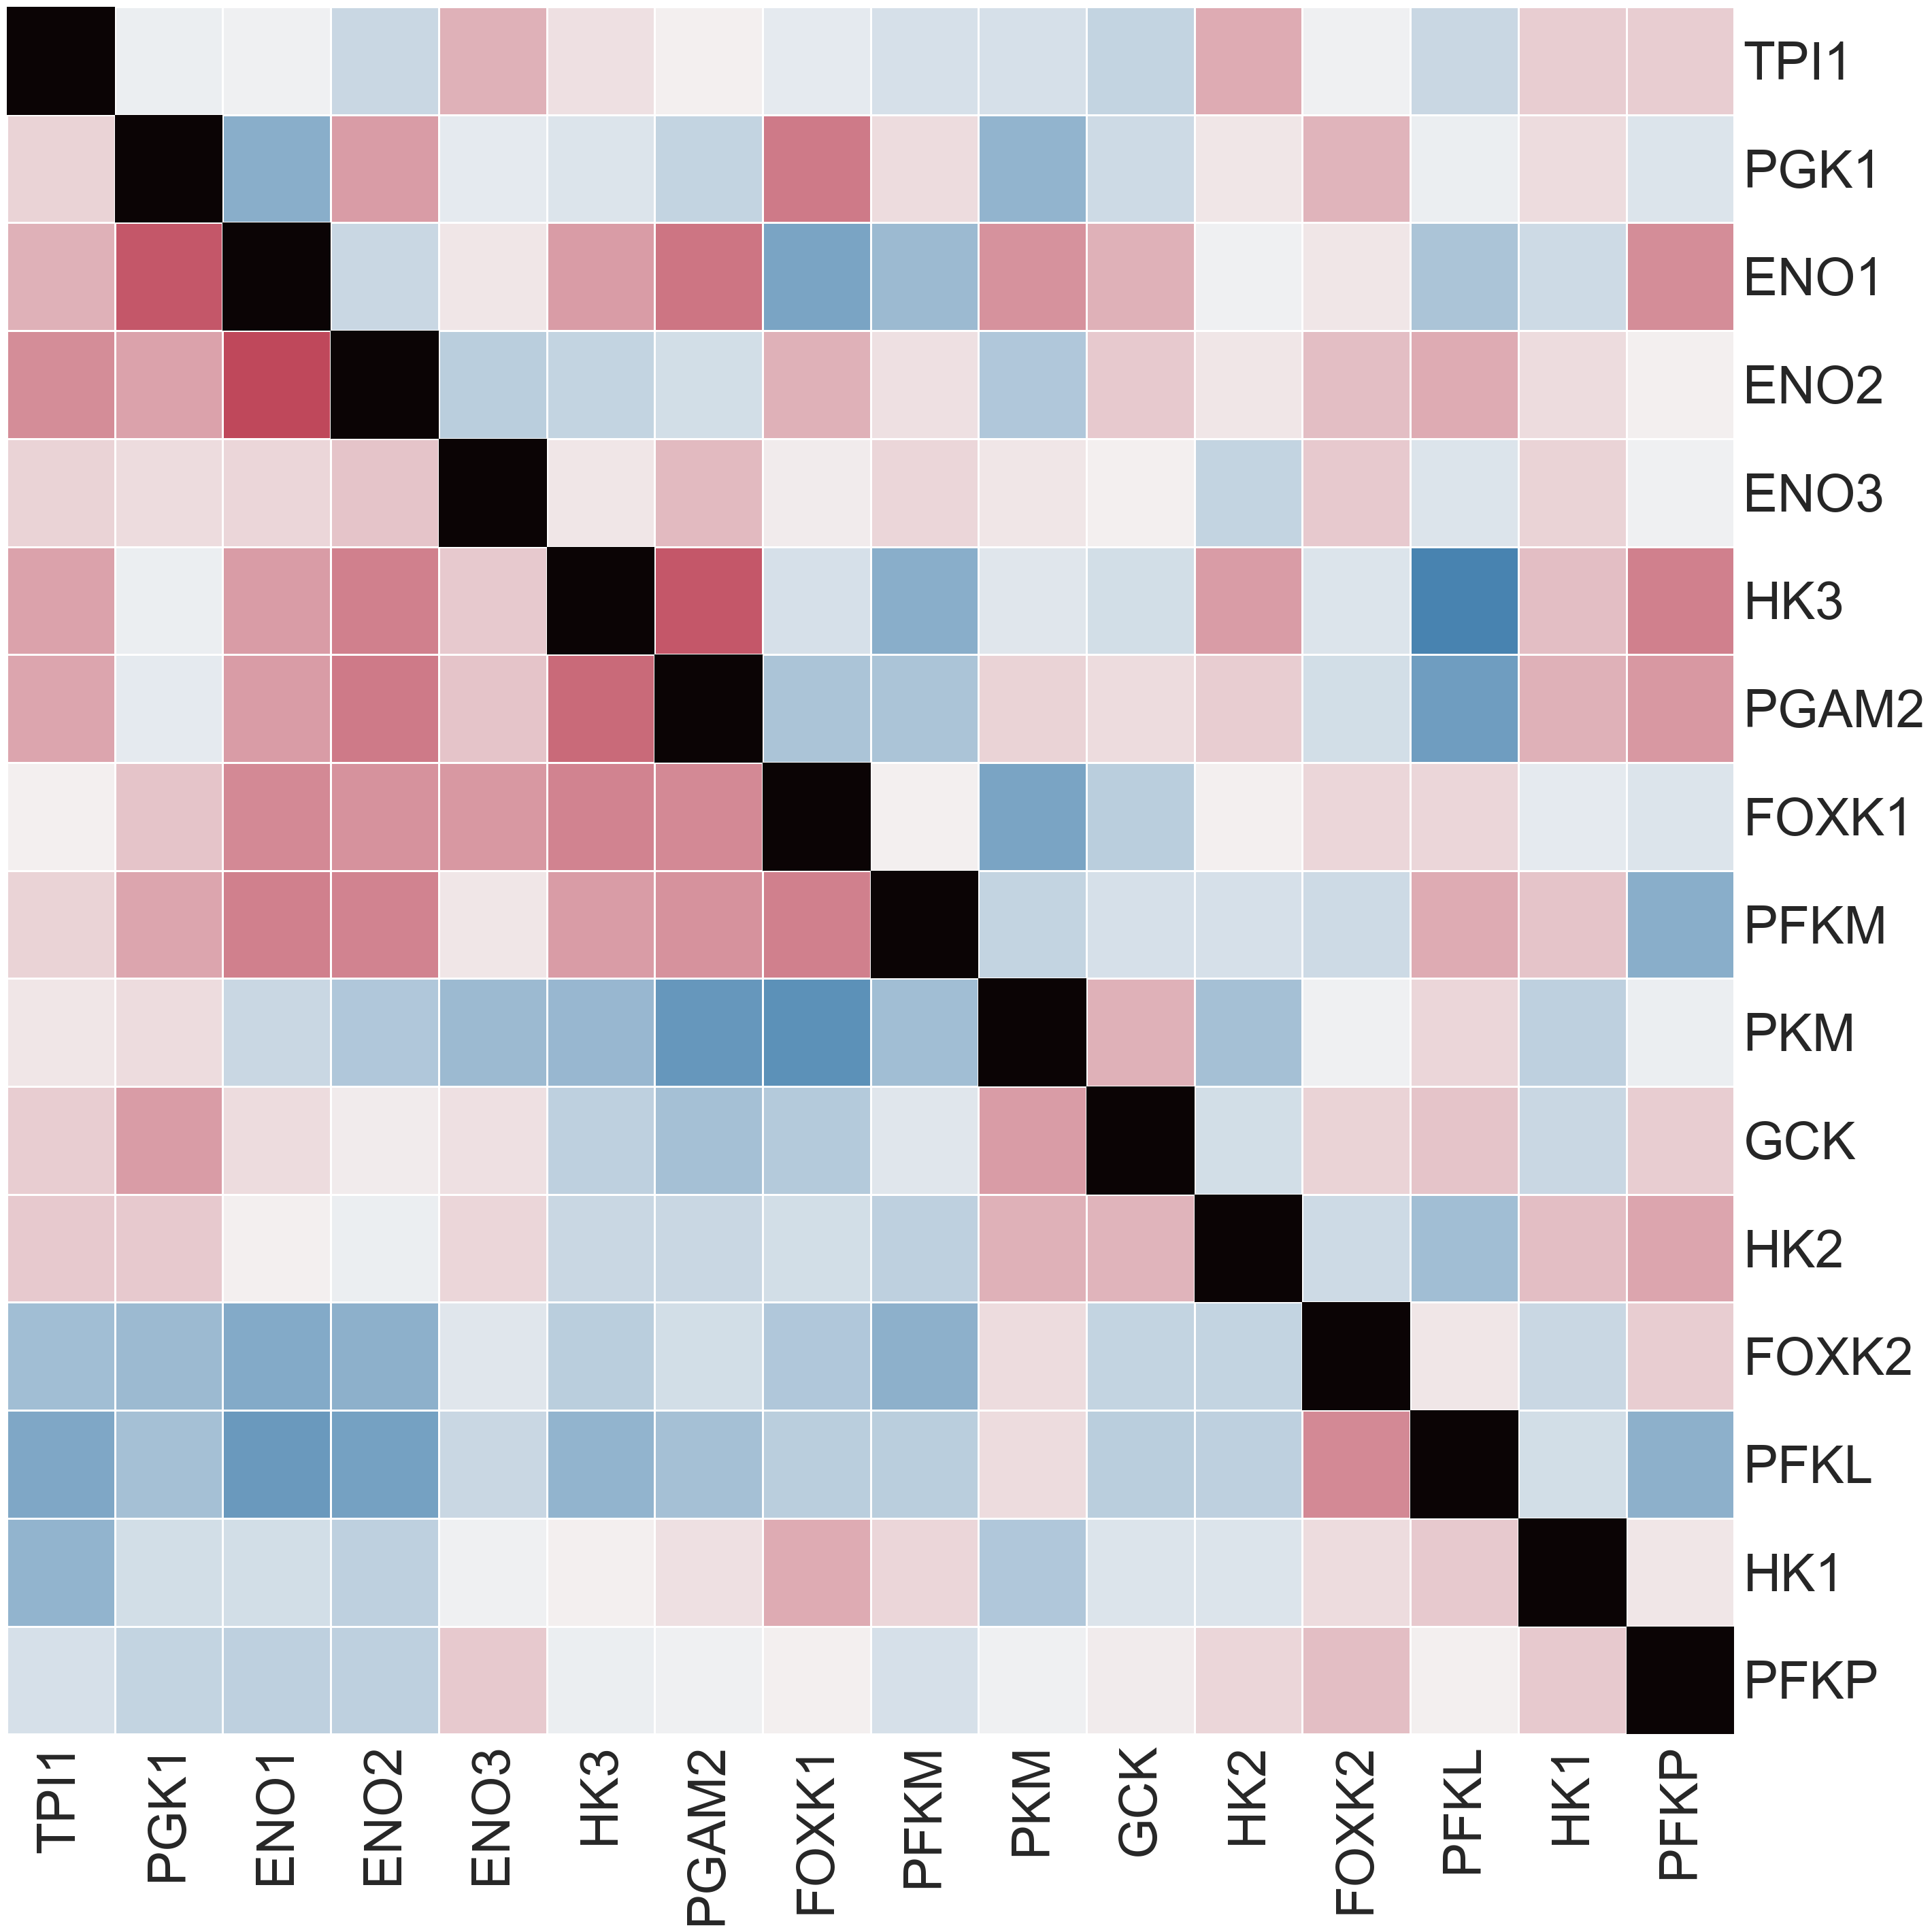

In [12]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',5)


<Figure size 1000x1000 with 0 Axes>

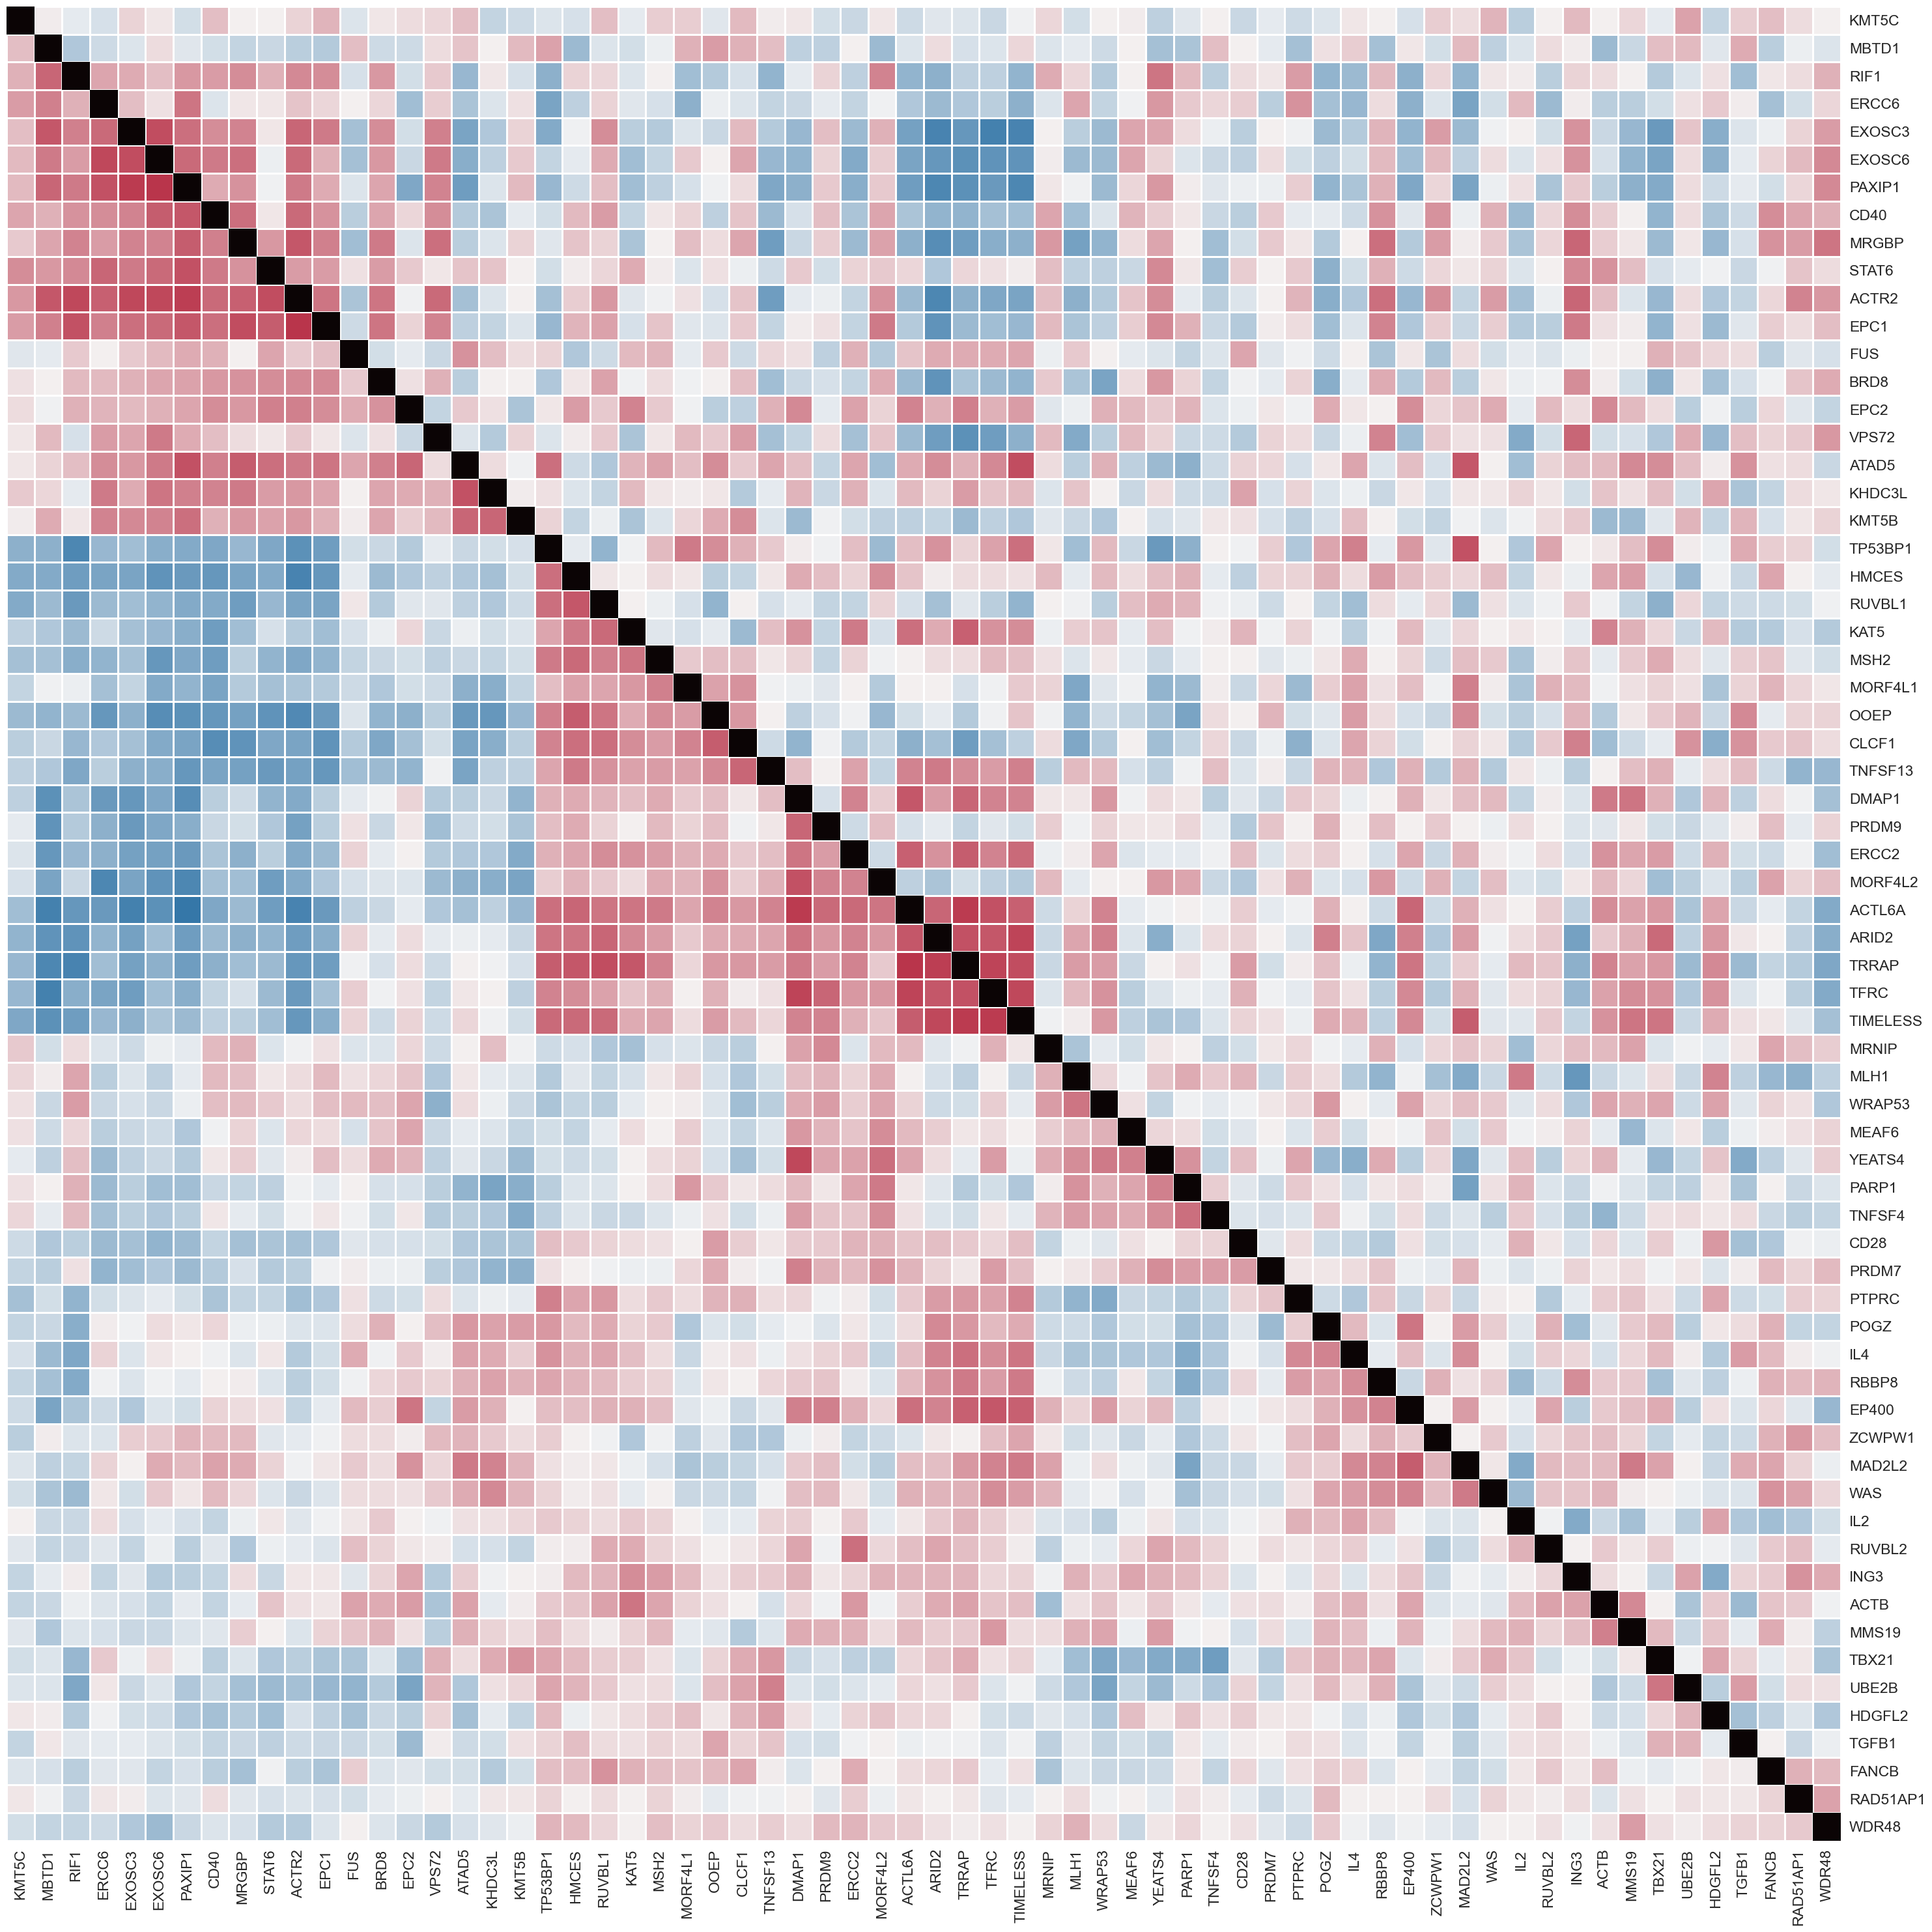

In [13]:
# Clustered based on the HPLM arm first
gene_set = 'POSITIVE_REGULATION_OF_DNA_RECOMBINATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',1.5)

<Figure size 1000x1000 with 0 Axes>

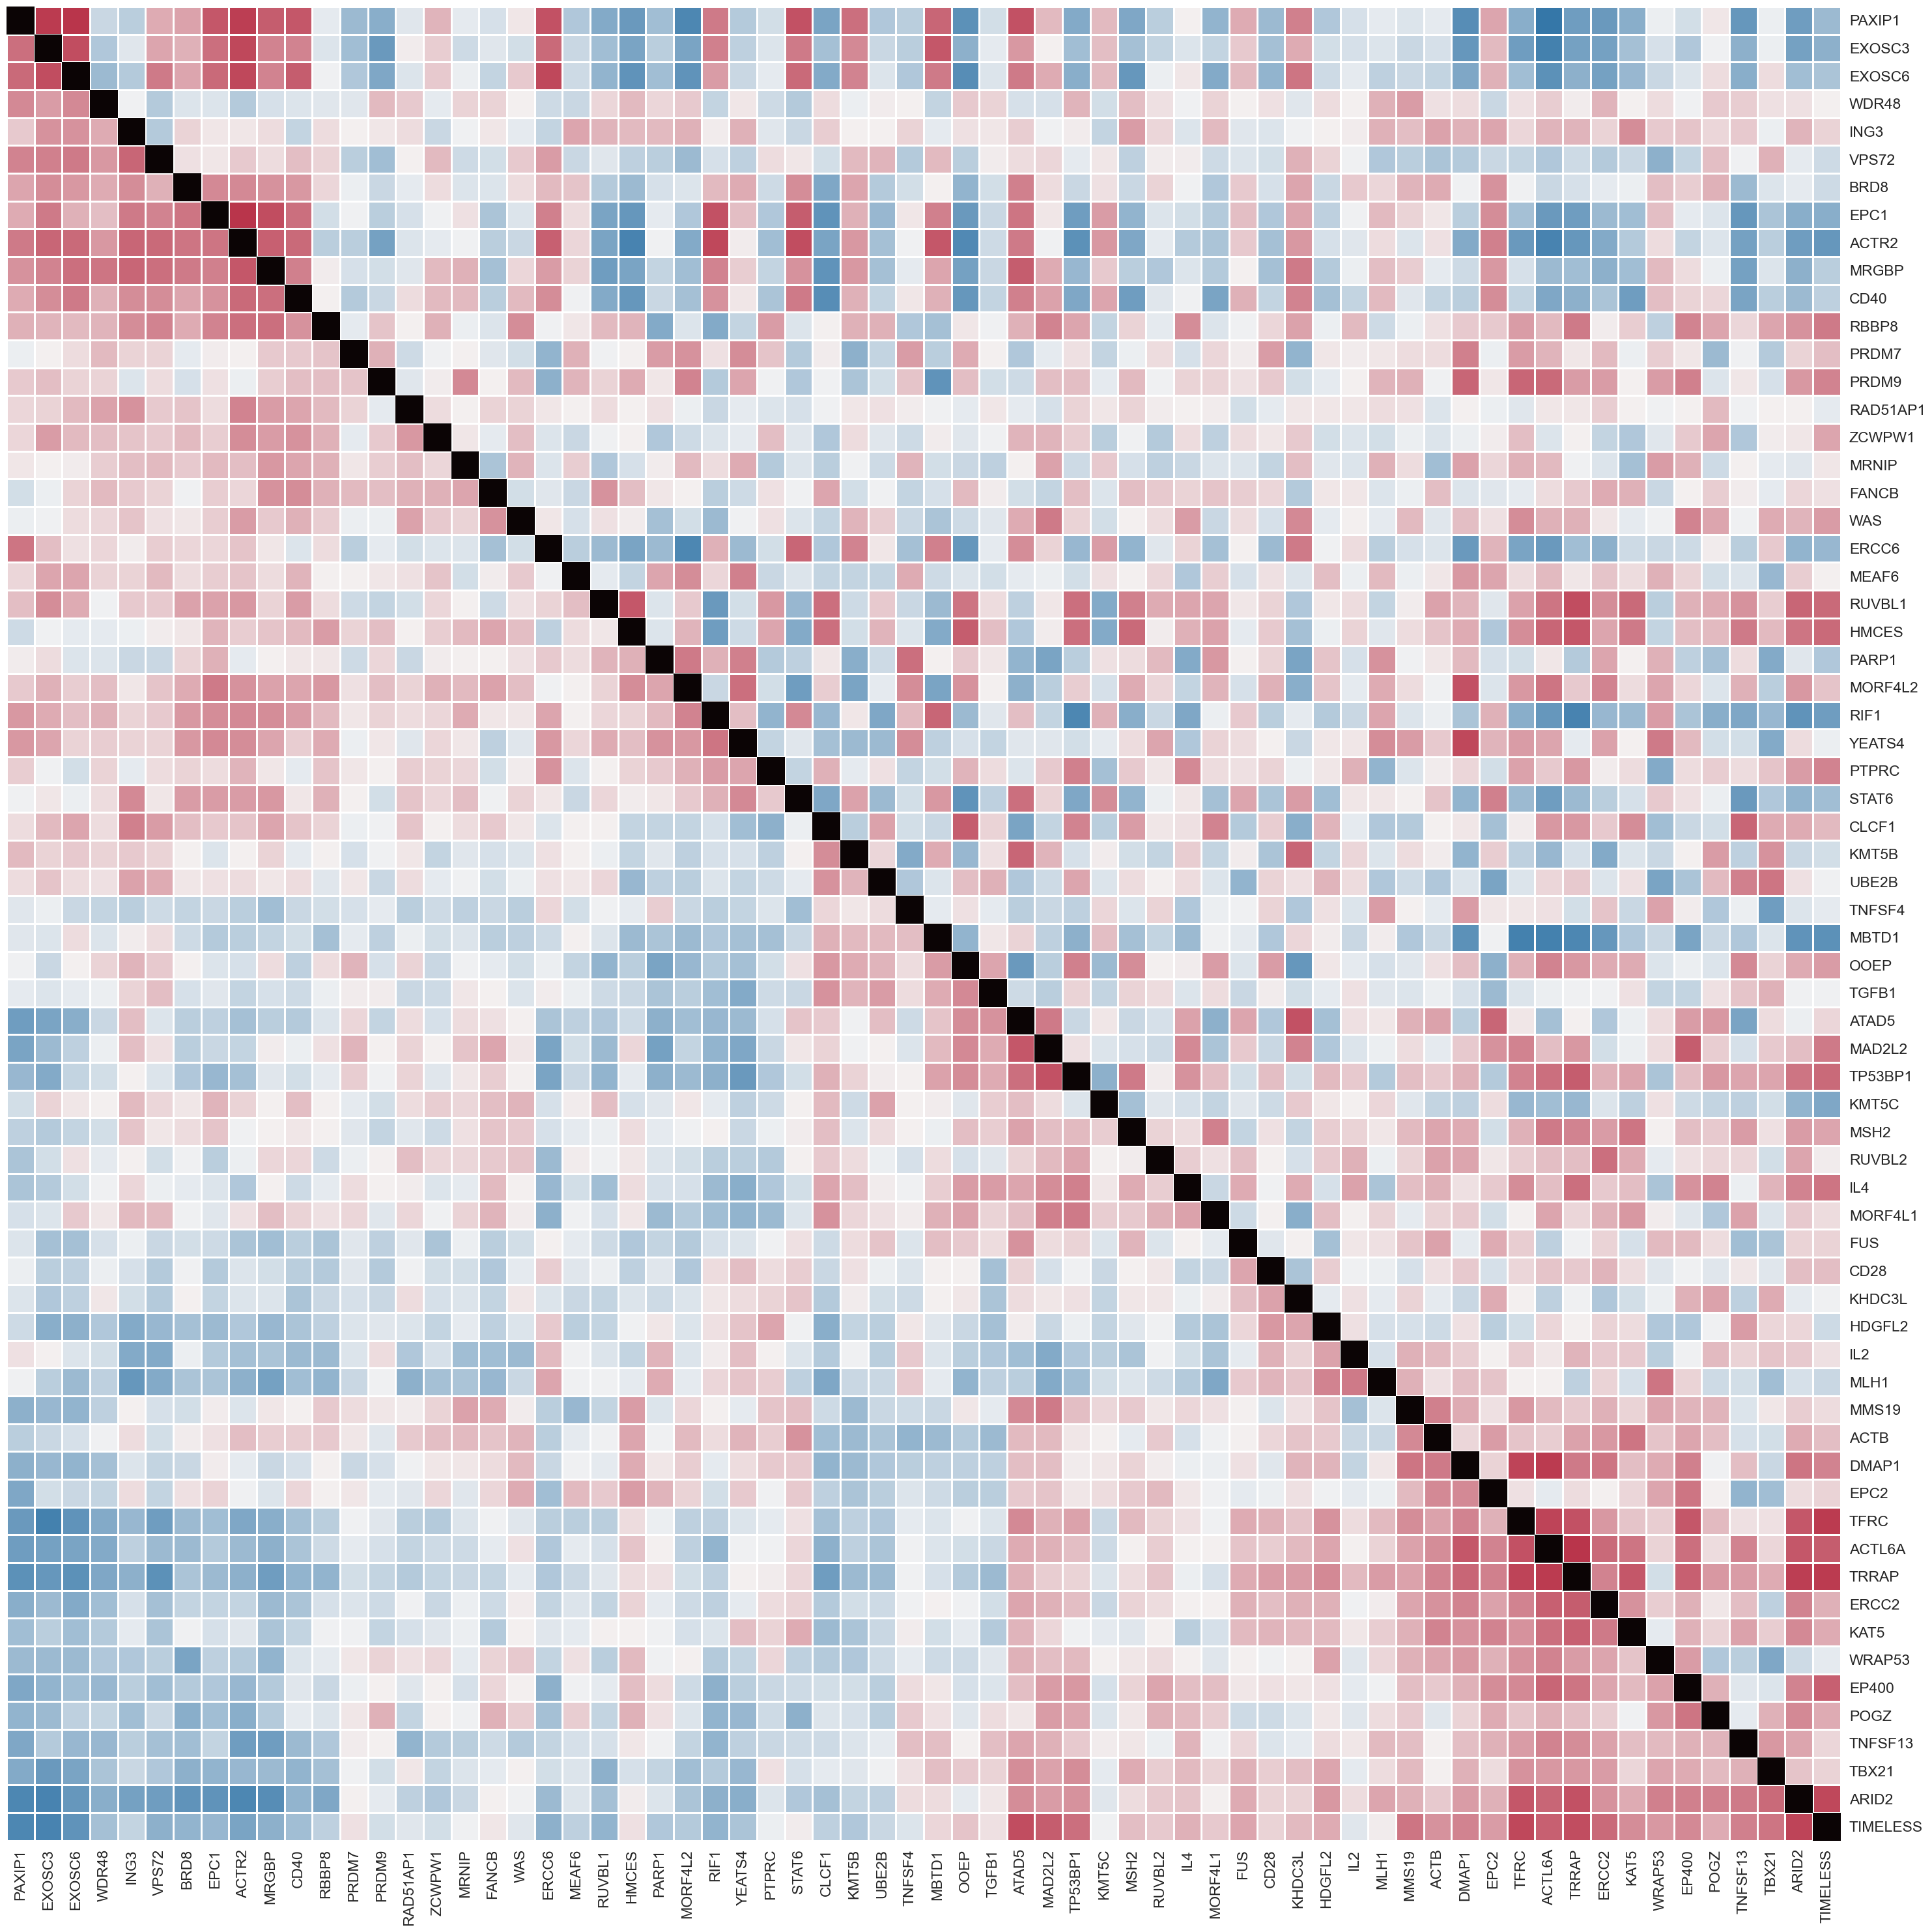

In [14]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',1.5,alt_view=True)